<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-CNN-Projects/blob/master/EuroSat-Classification-ResNet-Modell/efficientnetb0_eurosat_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# General Configuration

In [13]:
class Config:
    IMAGE_SIZE = (224, 224)
    BATCH_SIZE = 32
    NUM_CLASSES = 10
    EPOCHS_PH1 = 5
    EPOCHS_PH2 = 10
    FINETUNE_LR = 1e-5

config = Config()

# Download Dataset

In [3]:
dataset, info = tfds.load('eurosat/rgb', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.2QRZYE_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


## Check Samples

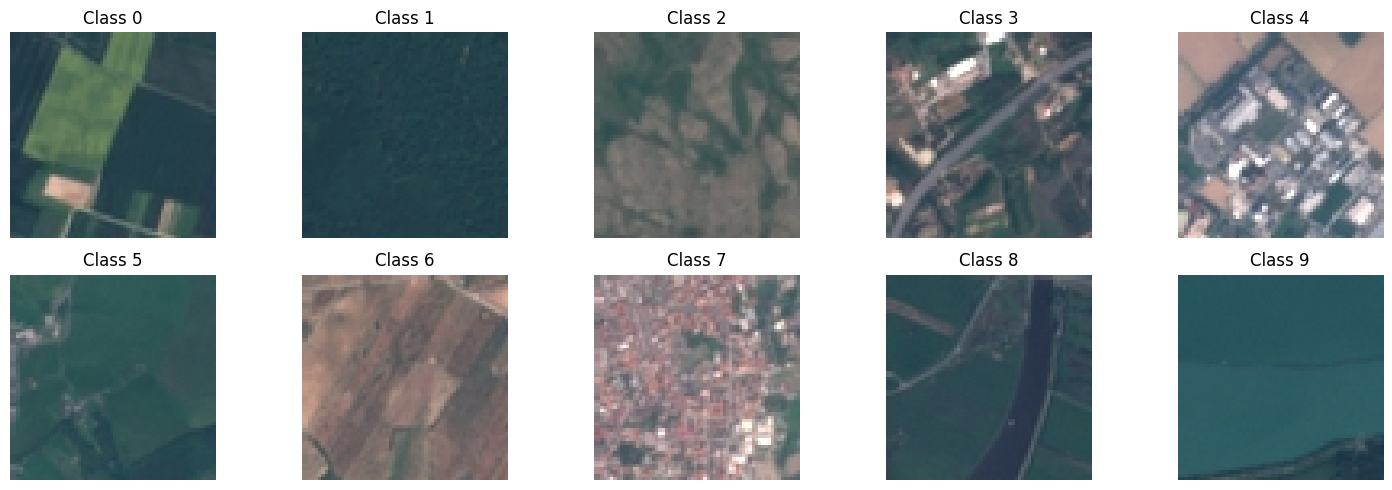

In [4]:
def get_one_sample_per_class(dataset, num_classes):
    samples = {}
    for image, label in dataset:
        label_np = label.numpy()
        if label_np not in samples:
            samples[label_np] = image.numpy()
        if len(samples) == num_classes:
            break
    return samples

train_dataset = dataset['train']
sample_images = get_one_sample_per_class(train_dataset, config.NUM_CLASSES)

plt.figure(figsize=(15, 5))
for i, (label, image) in enumerate(sorted(sample_images.items())):
    plt.subplot(2, (config.NUM_CLASSES + 1) // 2, i + 1) # Adjust subplot grid for better display
    plt.imshow(image)
    plt.title(f"Class {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# Preprocessing

In [37]:
# Preprocessing function: Resizes images and normalizes pixel values
def preprocess(image, label):
    # Resize image to the predefined IMAGE_SIZE (e.g., 224x224)
    image = tf.image.resize(image, config.IMAGE_SIZE)
    # Normalize image pixel values to the [0, 1] range
    # This is crucial for neural networks to ensure stable training
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Define Keras augmentation layers for efficient and diverse data augmentation
# These layers operate on float32 images in the [0, 1] range.
_data_augmentation_pipeline = tf.keras.Sequential([
    # Randomly flip the image horizontally, vertically, or both
    # Helps the model be invariant to object orientation
    layers.RandomFlip("horizontal_and_vertical"),
    # Randomly rotate the image by a factor (e.g., 0.15 means +/- 15% of 2*pi radians, approx. 54 degrees)
    # Enhances robustness to different object rotations
    layers.RandomRotation(factor=0.15),
    # Randomly zoom in or out on the image by up to 20%
    # Aids in recognizing objects at various scales
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    # Randomly translate (shift) the image horizontally and vertically by up to 20%
    # 'nearest' fill_mode fills empty spaces with the nearest pixel value
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
    # Randomly adjust image brightness by up to 20%
    # Improves generalization across different lighting conditions
    layers.RandomBrightness(factor=0.2),
    # Randomly adjust image contrast by up to 20%
    # Similar to brightness, helps with varying illumination
    layers.RandomContrast(factor=0.2),
])

# Augmentation function: Applies the defined data augmentation pipeline
def augment(image, label):
    # Apply the sequence of Keras data augmentation layers
    augmented_image = _data_augmentation_pipeline(image)
    # Ensure image pixel values remain within the [0, 1] range after augmentations
    # This prevents values from going out of bounds due to transformations
    augmented_image = tf.clip_by_value(augmented_image, 0.0, 1.0)
    return augmented_image, label

In [38]:
# Split dataset
DATA_SIZE = info.splits["train"].num_examples
train_size = int(0.8 * DATA_SIZE)

full_ds = dataset["train"].shuffle(1000)
train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size)

In [39]:
# Create tf pipeline
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(config.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(config.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Dataset ready. Classes: {info.features["label"].names}")

Dataset ready. Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


# Loading `EfficientNetB0`

**Phase #1**

In [45]:
# Load EfficientNetB0, a pre-trained convolutional neural network.
# 'imagenet' weights are used for transfer learning, leveraging features learned on a large dataset.
# 'include_top=False' means we are discarding the original classification head of EfficientNetB0,
# allowing us to add our own custom classification layers for the specific task.
# 'input_shape' defines the expected input image dimensions (e.g., 224x224 pixels with 3 color channels).
base_model = tf.keras.applications.EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(*config.IMAGE_SIZE, 3),
)

# Freezing Base Layers: Initially, the weights of the pre-trained EfficientNetB0 base model
# are set to be non-trainable. This prevents them from being updated during the first phase of training,
# allowing the new classification head to learn task-specific features without altering the powerful
# generic features extracted by the EfficientNetB0.
base_model.trainable = False

# Function to add new classification heads on top of the base model.
# This custom head will be trained for our specific dataset.
def add_heads(base_model, num_classes):
    # Define the input layer with the expected image shape.
    inputs = layers.Input(shape=(*config.IMAGE_SIZE, 3))
    # Pass the input through the pre-trained base model.
    # 'training=False' ensures that BatchNorm layers in the base model run in inference mode,
    # using their pre-computed means and variances, which is appropriate when freezing the base.
    x = base_model(inputs, training=False)
    # Apply GlobalAveragePooling2D to reduce the spatial dimensions of the feature maps
    # to a single vector per feature map. This prepares the output for the dense layers.
    x = layers.GlobalAveragePooling2D()(x)
    # Add a Dropout layer to randomly set a fraction of input units to 0 at each update during training.
    # This helps prevent overfitting by forcing the network to learn more robust features.
    x = layers.Dropout(0.5)(x)
    # Add the final Dense classification layer.
    # 'num_classes' is the number of distinct categories in our dataset.
    # 'softmax' activation is used for multi-class classification to output probabilities for each class.
    # 'kernel_regularizer=regularizers.l2(0.001)' adds L2 regularization to the weights of this layer.
    # L2 regularization penalizes large weights, which helps reduce model complexity and mitigate overfitting.
    outputs = layers.Dense(num_classes,
                           activation="softmax",
                           kernel_regularizer=regularizers.l2(0.001))(x)
    # Create the Keras Model by specifying its inputs and outputs.
    return tf.keras.Model(inputs, outputs)

# Instantiate the model by calling the add_heads function with the base model and number of classes.
model = add_heads(base_model, config.NUM_CLASSES)

In [46]:
# Compile Model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [47]:
# Training
history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config.EPOCHS_PH1,
)

Epoch 1/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 64s 65ms/step - accuracy: 0.7544 - loss: 0.8255 - val_accuracy: 0.9381 - val_loss: 0.2152
Epoch 2/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.9137 - loss: 0.2776 - val_accuracy: 0.9446 - val_loss: 0.1834
Epoch 3/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.9197 - loss: 0.2461 - val_accuracy: 0.9520 - val_loss: 0.1626
Epoch 4/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - accuracy: 0.9261 - loss: 0.2299 - val_accuracy: 0.9544 - val_loss: 0.1568
Epoch 5/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.9284 - loss: 0.2232 - val_accuracy: 0.9548 - val_loss: 0.1516


**Phase #2**

In [52]:
# Define a list of callbacks to enhance the training process.
my_callbacks = [
    # EarlyStopping callback monitors a quantity (e.g., validation loss) and stops training
    # if it stops improving after a certain number of epochs (patience).
    # This helps prevent overfitting by not training for too long.
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',         # Quantity to be monitored (validation loss).
        patience=5,                 # Number of epochs with no improvement after which training will be stopped.
        restore_best_weights=True,  # Restores model weights from the epoch with the best value of the monitored quantity.
        verbose=1                   # Verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch).
    ),
    # ReduceLROnPlateau callback reduces the learning rate when a metric has stopped improving.
    # This can help the model converge more effectively once it's close to an optimum.
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',         # Quantity to be monitored (validation loss).
        factor=0.2,                 # Factor by which the learning rate will be reduced. new_lr = lr * factor.
        patience=3,                 # Number of epochs with no improvement after which learning rate will be reduced.
        min_lr=1e-6,                # Lower bound on the learning rate.
        verbose=1                   # Verbosity mode.
    )
]

In [53]:
# Unfreeze a portion of the base model for fine-tuning.
# Setting `base_model.trainable = True` makes all layers in the base model trainable by default.
base_model.trainable = True

# Determine how many layers to unfreeze. We choose to unfreeze the last 50 layers of the base model.
# This allows the deeper, more generic layers to remain frozen, preserving their learned features,
# while the shallower, more task-specific layers can adapt to our dataset.
fine_tune_at = len(base_model.layers) - 50

# Explicitly set the earlier layers (up to fine_tune_at) to non-trainable.
# This ensures that only the intended last 'fine_tune_at' layers are updated during fine-tuning.
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-Compile the model for fine-tuning.
# It's crucial to re-compile the model after modifying `trainable` attributes
# for the changes to take effect during training.
# A much smaller learning rate (config.FINETUNE_LR, typically 1e-5 or 1e-6) is used
# to make small, precise adjustments to the pre-trained weights without disrupting them too much.
model.compile(
    optimizer=optimizers.Adam(learning_rate=config.FINETUNE_LR),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print(f"Number of layers in base model: {len(base_model.layers)}")
print(f"Training starts from layer {fine_tune_at} onwards.")

# Train the model for Phase 2 (fine-tuning).
# `initial_epoch=history_phase1.epoch[-1]` continues training from where Phase 1 left off.
# Callbacks (EarlyStopping and ReduceLROnPlateau) are now included to manage the training process,
# preventing overfitting and optimizing the learning rate dynamically.
history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config.EPOCHS_PH2,
    initial_epoch=history_phase1.epoch[-1],
    callbacks=my_callbacks
)

Number of layers in base model: 238
Training starts from layer 188 onwards.
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 80s 76ms/step - accuracy: 0.8106 - loss: 0.6065 - val_accuracy: 0.9352 - val_loss: 0.2122 - learning_rate: 1.0000e-05
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 44s 65ms/step - accuracy: 0.8866 - loss: 0.3623 - val_accuracy: 0.9483 - val_loss: 0.1743 - learning_rate: 1.0000e-05
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.9085 - loss: 0.2938 - val_accuracy: 0.9528 - val_loss: 0.1611 - learning_rate: 1.0000e-05
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - accuracy: 0.9162 - loss: 0.2671 - val_accuracy: 0.9580 - val_loss: 0.1492 - learning_rate: 1.0000e-05
Epoch 9/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 44s 65ms/step - accuracy: 0.9226 - loss: 0.2485 - val_accuracy: 0.9593 - val_loss: 0.1416 - learning_rate: 1.0000e-05
Epoch 10/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.9276 - loss: 0.2331 - val_accuracy: 0.9622 - val_loss: 0.1291 - l

# Evaluation

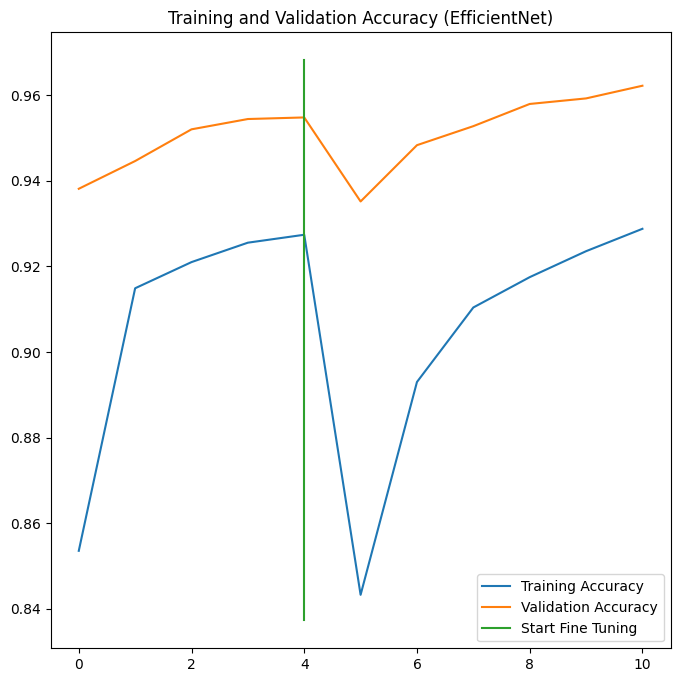

In [54]:
# Concatenate accuracy and validation accuracy from both training phases.
# history_phase1.history contains metrics from the first training phase (frozen base model).
# history_phase2.history contains metrics from the second training phase (fine-tuned base model).
acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']

# Create a figure for the plot with a specified size.
plt.figure(figsize=(8, 8))

# Plot the training accuracy over all epochs.
plt.plot(acc, label='Training Accuracy')
# Plot the validation accuracy over all epochs.
plt.plot(val_acc, label='Validation Accuracy')

# Add a vertical line to indicate the start of the fine-tuning phase.
# In this case, EPOCHS_PH1 = 5, so fine-tuning starts after the 5th epoch (index 4).
plt.plot([config.EPOCHS_PH1 - 1, config.EPOCHS_PH1 - 1], plt.ylim(), label='Start Fine Tuning')

# Display the legend to identify each plotted line.
plt.legend(loc='lower right')
# Set the title of the plot.
plt.title('Training and Validation Accuracy (EfficientNet)')
# Show the plot.
plt.show()
